<h1 style="text-align: center;">Facial Expression Detection</h1>

Dataset can be downloaded [here](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from datetime import datetime

In [160]:
## Class for getting the data
class ExpressionDataset(Dataset):
    def __init__(self, filename, img_size=(48,48), transform=None):
        self.data = pd.read_csv(filename)
        self.img_height = img_size[0]
        self.img_width = img_size[0]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.loc[idx, "pixels"]
        target = self.data.loc[idx, "emotion"]

        ## changing the image pixel string into actual image
        img = []
        row = []
        for pixel in pixels.split():
            if len(row) == self.img_width:
                img.append(row)
                row = []

            row.append(np.uint8(pixel))

        ## appending last row
        img.append(row)
        img = np.array(img)

        if self.transform:
            img = self.transform(img)

        return img, target

In [161]:
import os

In [162]:
## getting labels
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

In [163]:
## filepaths for data
# creating transforms for the data
data_transforms = transforms.ToTensor()
data_folder = "x__data"
train_path = os.path.join(data_folder, "train.csv")
dataset = ExpressionDataset(train_path, transform=data_transforms)

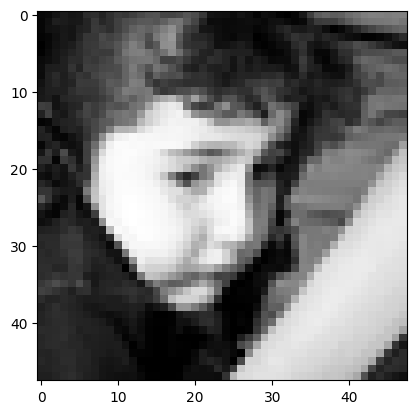

In [164]:
rand_ind = np.random.choice(len(train_dataset))
img, target = train_dataset[rand_ind]

plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()

In [165]:
## splitting the train dataset into train and validation
valid_size = 0.3
train_size = 1 - valid_size
train_dataset, validation_dataset = random_split(dataset, [train_size,  valid_size])

In [166]:
## creating data loaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [167]:
## creating model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.K = output_size

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.2)
            nn.Linear(12*12*64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            nn.Linear(64, self.K)
        )

    def forward(self, X):
        out = self.cnn(X)
        out = self.fc(out.view(out.shape[0], -1))
        return out

In [168]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [169]:
model = CNN(len(labels))
model.to(device)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [170]:
## creating criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [171]:
## creating batch gradient descent function
def batch_gd(model, criterion, optimizer, train_loader, validation_loader, epochs=20):
    train_losses = []
    validation_losses = []

    for it in range(epochs):
        t0 = datetime.now()
        epoch_losses = []
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            
        train_losses.append(np.mean(epoch_losses))

        
        epoch_losses = []
        model.eval()
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_losses.append(loss.item())
            
        validation_losses.append(np.mean(epoch_losses))

        dt = datetime.now() - t0

        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]}, Validation Loss: {validation_losses[it]}, Duration: {dt}")

    return train_losses, validation_losses

In [172]:
train_losses, validation_losses = batch_gd(model,
                                           criterion,
                                           optimizer,
                                           train_loader,
                                           validation_loader,
                                           epochs=10
                                          )

Epoch 1/20, Train Loss: 1.7325755810435814, Validation Loss: 1.650088534635656, Duration: 0:02:08.075358
Epoch 2/20, Train Loss: 1.5832188755651064, Validation Loss: 1.5536580857108622, Duration: 0:02:16.443443
Epoch 3/20, Train Loss: 1.4845827916000462, Validation Loss: 1.477905834422392, Duration: 0:02:18.043412
Epoch 4/20, Train Loss: 1.404763786098625, Validation Loss: 1.490687675335828, Duration: 0:02:11.583467
Epoch 5/20, Train Loss: 1.3312121101572543, Validation Loss: 1.4031541557872997, Duration: 0:02:28.644642
Epoch 6/20, Train Loss: 1.2669855077055436, Validation Loss: 1.3947903531439163, Duration: 0:02:25.703899
Epoch 7/20, Train Loss: 1.2049141575146136, Validation Loss: 1.3670829902676975, Duration: 0:02:28.433485
Epoch 8/20, Train Loss: 1.1285945097974772, Validation Loss: 1.334957124555812, Duration: 0:02:24.452531
Epoch 9/20, Train Loss: 1.0717151957222177, Validation Loss: 1.3645087200052597, Duration: 0:02:25.804012
Epoch 10/20, Train Loss: 1.036829798659192, Validat

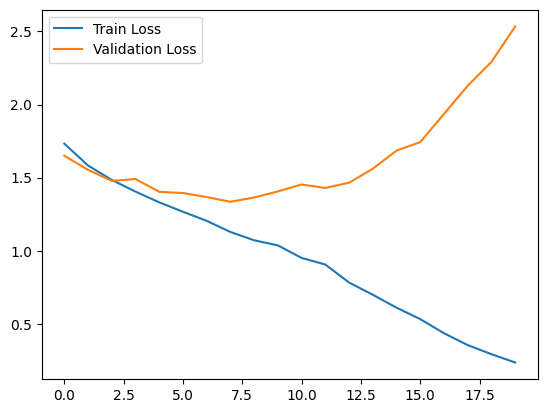

In [173]:
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.show()

In [174]:
## getting accuracy
with torch.no_grad():
    model.eval()
    n_correct = 0
    count = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        n_correct += sum(preds == targets).item()
        count += len(targets)

    train_acc = n_correct/count
    
    n_correct = 0
    count = 0
    for inputs, targets in validation_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        n_correct += sum(preds == targets).item()
        count += len(targets)

    validation_acc = n_correct/count

print(f"Train Accuracy: {train_acc}, Validation Accuracy: {validation_acc}")

Train Accuracy: 0.9489973627904662, Validation Accuracy: 0.5037157454714352
